In [25]:
# 25 May 2025

<h1 style="line-height:3rem;"> Titanic </h1>

In [77]:
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 80/20 split


import os

def load_data():
    env_name = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost')
    if env_name == "Localhost":
        df = pd.read_csv('../datasets/New/Titanic.csv', low_memory=False)
    else:
        df = pd.read_csv("/kaggle/input/Titanic/Titanic.csv")
    return df


def create_age_sex_survival_table(df, age_col='Age', sex_col='Sex', survived_col='Survived'):
    # Clean column names
    df.columns = [col.strip() for col in df.columns]

    # Drop rows with missing Age, Sex, or Survived
    df = df.dropna(subset=[age_col, sex_col, survived_col]).copy()

    # Convert to categorical if necessary
    if df[sex_col].dtype != 'O':
        df[sex_col] = df[sex_col].map({0: 'female', 1: 'male'})

    # Create 5-year age bins
    bins = list(range(0, 64 + 5, 5))
    labels = [f'{i}-{i+4}' for i in bins[:-1]]
    df['AgeGroup'] = pd.cut(df[age_col], bins=bins, labels=labels, right=False)

    # Group by AgeGroup and Sex
    summary = df.groupby(['AgeGroup', sex_col], observed=True)[survived_col].agg(
        Total='count',
        Survived='sum'
    ).reset_index()

    # Pivot the table for better structure
    table = summary.pivot(index='AgeGroup', columns=sex_col, values=['Total', 'Survived'])
    table.columns = ['_'.join(col).capitalize() for col in table.columns]
    table = table.fillna(0).astype(int)


    # Compute survival percentages
    table['Sur_Male_%'] = (table.get('Survived_male', 0) / table.get('Total_male', 1) * 100).round(2)
    table['Sur_Female_%'] = (table.get('Survived_female', 0) / table.get('Total_female', 1) * 100).round(2)

    # Sort index
    table = table.sort_index()

    # Add Total row
    total_row = pd.DataFrame(table.sum(numeric_only=True)).T
    total_row.index = ['Total']
    total_row['Sur_Male_%'] = (table['Survived_male'].sum() / table['Total_male'].sum() * 100).round(2)
    total_row['Sur_Female_%'] = (table['Survived_female'].sum() / table['Total_female'].sum() * 100).round(2)

    # Append total row
    table = pd.concat([table, total_row])

    return table

# Load dataset
df = load_data()

# Generate summary table
age_sex_survival_table = create_age_sex_survival_table(df)

# Display styled table (in Jupyter notebooks)


styled_table = age_sex_survival_table.style.format({
    'Sur_Male_%': '{:.2f}',
    'Sur_Female_%': '{:.2f}',
    'Survived_male': '{:.0f}',
    'Survived_female': '{:.0f}',
    'Total_male': '{:.0f}',
    'Total_female': '{:.0f}'
}).background_gradient(
    cmap='BuGn',
    subset=['Survived_male', 'Survived_female', 'Sur_Male_%', 'Sur_Female_%']
)

styled_table


,Total_female,Total_male,Survived_female,Survived_male,Sur_Male_%,Sur_Female_%
0-4,17,23,12,15,65.22,70.59
5-9,13,9,7,4,44.44,53.85
10-14,9,7,5,2,28.57,55.56
15-19,36,50,29,5,10.00,80.56
20-24,42,72,32,7,9.72,76.19
25-29,30,76,20,18,23.68,66.67
30-34,33,62,27,13,20.97,81.82
35-39,27,45,23,10,22.22,85.19
40-44,18,30,13,5,16.67,72.22
45-49,14,27,9,7,25.93,64.29


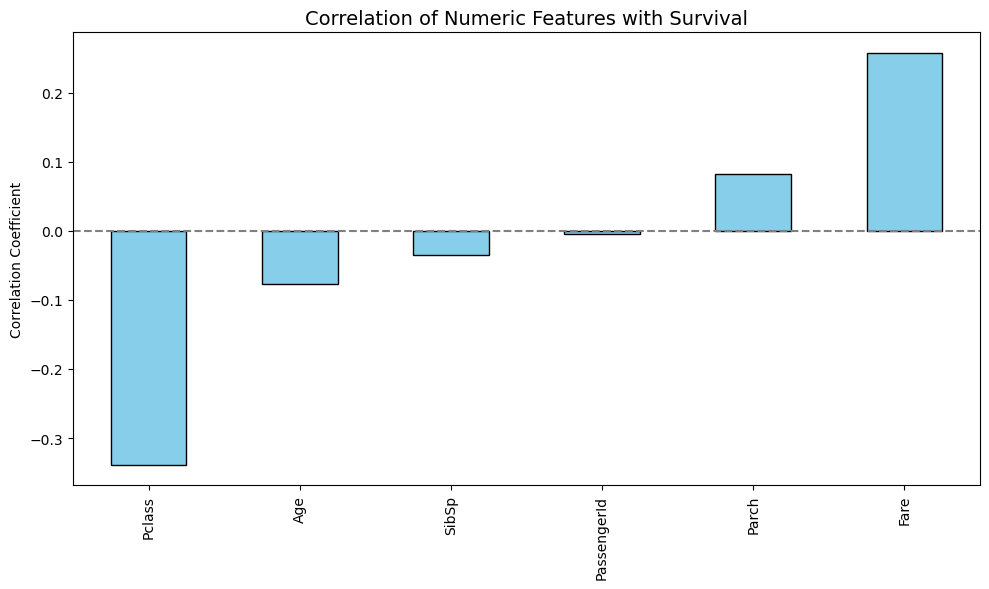

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns



numeric_df = df.select_dtypes(include=['number']).copy()

numeric_df = numeric_df.dropna(subset=['Survived'])

# Compute correlation with 'Survived'
correlations = numeric_df.corr(numeric_only=True)['Survived'].drop('Survived')

# Plot the correlations
plt.figure(figsize=(10, 6))
correlations.sort_values().plot(kind='bar', color='skyblue', edgecolor='black')
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Correlation of Numeric Features with Survival', fontsize=14)
plt.ylabel('Correlation Coefficient')
plt.tight_layout()
plt.show()


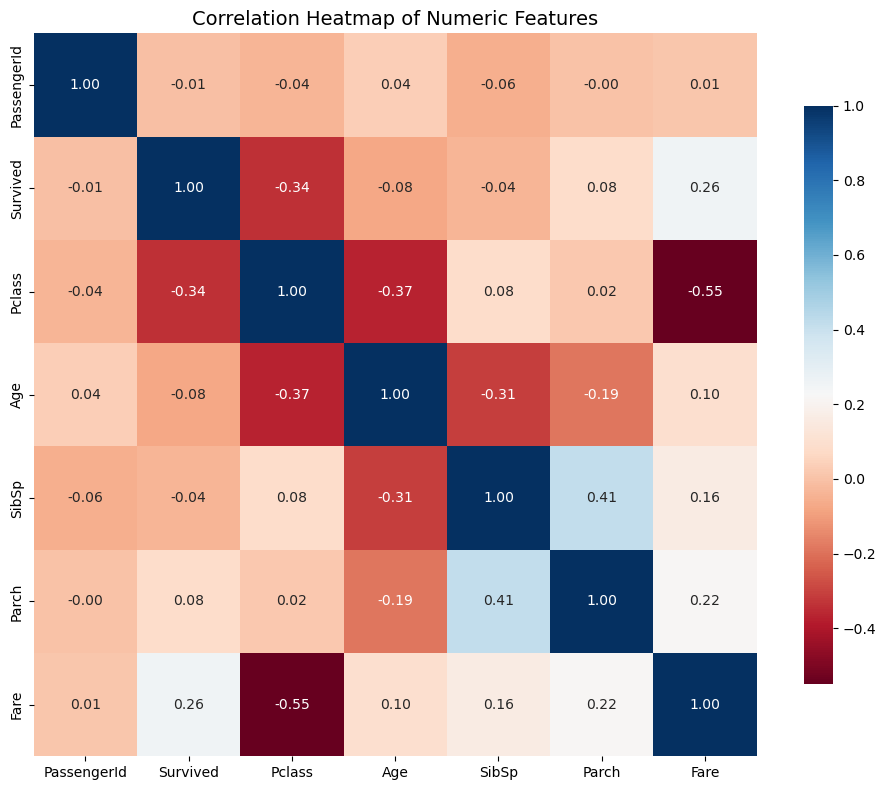

In [29]:
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdBu', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Numeric Features', fontsize=14)
plt.tight_layout()
plt.show()

In [79]:

# 80/20 split

df_train = load_data()
df_train_split, df_test_split = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train['Survived'])

# Confirm shape
print(f"Train size: {df_train_split.shape}")
print(f"Test size : {df_test_split.shape}")



# Compute survival ratio by gender in train data
gender_survival_ratio = df_train_split.groupby('Sex')['Survived'].mean().round(2)

print("Survival ratios by gender (train set):")
print(gender_survival_ratio)
print('')
print('')

print("#####################")
print("#####################")

print()
print()
# Define rule: if female survival rate > 0.5 → female survives
rules = {
    'female': int(gender_survival_ratio['female'] > 0.5),
    'male': int(gender_survival_ratio['male'] > 0.5)
}

# Apply rule-based prediction
df_test_split['Naive_Pred'] = df_test_split['Sex'].map(rules)


print('')
print('')



# Accuracy
accuracy = accuracy_score(df_test_split['Survived'], df_test_split['Naive_Pred'])
conf_mat = confusion_matrix(df_test_split['Survived'], df_test_split['Naive_Pred'])
report = classification_report(df_test_split['Survived'], df_test_split['Naive_Pred'], target_names=['Died', 'Survived'])

print(f"Accuracy on test data: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_mat)
print("\nClassification Report:\n", report)



Train size: (712, 12)
Test size : (179, 12)
Survival ratios by gender (train set):
Sex
female    0.74
male      0.19
Name: Survived, dtype: float64


#####################
#####################




Accuracy on test data: 0.78
Confusion Matrix:
 [[94 16]
 [24 45]]

Classification Report:
               precision    recall  f1-score   support

        Died       0.80      0.85      0.82       110
    Survived       0.74      0.65      0.69        69

    accuracy                           0.78       179
   macro avg       0.77      0.75      0.76       179
weighted avg       0.77      0.78      0.77       179

